In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

In [2]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
def is_not_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score <= thresh

def VisualizeFeatures(layer, legend = "weights", remove_outlier = True, df = None):
    w = layer.weight.clone().detach().cpu().numpy()
    w = w.flatten()
    
    MAX_LEN = 16384
    
    if len(w) > MAX_LEN:
        w = np.random.choice(w, MAX_LEN)
        
    if remove_outlier:
        w = w[is_not_outlier(w)]
        
    _df = pd.DataFrame({legend: w})
    if df is not None:
        df = pd.concat([df, _df], axis = 1)
    else:
        df = _df
        
    plt.figure(figsize=(10,5))
    sns.histplot(df, fill = True, kde = True).set(title='Features of - %s' % (repr(layer)))
    plt.show()
    
    return df

In [3]:
class LitClassifier(pl.LightningModule):
    
    def __init__(self, input_dim, output_dim, hidden_dim, nonlin = nn.ReLU()):
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nonlin,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        embedding = self.net(x)
        return embedding

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        
        x = x.view(x.size(0), -1)
        logits = self(x)
        
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        pass

In [4]:
class LitAutoEncoder(pl.LightningModule):
    
    def __init__(self, input_dim, output_dim, hidden_dim, nonlin = nn.ReLU(), noiseAmount = 0.3):
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nonlin,
#             nn.Linear(hidden_dim, output_dim)
        )
        
        self.decoder = nn.Sequential(
#             nn.Linear(output_dim, hidden_dim),
#             nonlin,
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
        self.noiseAmount = noiseAmount

    def forward(self, x):
        embedding = self.encoder(x)
        return embedding

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)
        xx = x.clone()
        
        # TODO: Apply noise here
        mask = (torch.rand_like(x) < self.noiseAmount)
        x[mask] = 0.0
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        # TODO: Apply mask here
#         loss = F.mse_loss(x_hat, x)
        loss = F.mse_loss(x_hat * mask, xx * mask, reduction = 'sum') / (mask.long().sum())
        
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)

0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/home/betairya/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


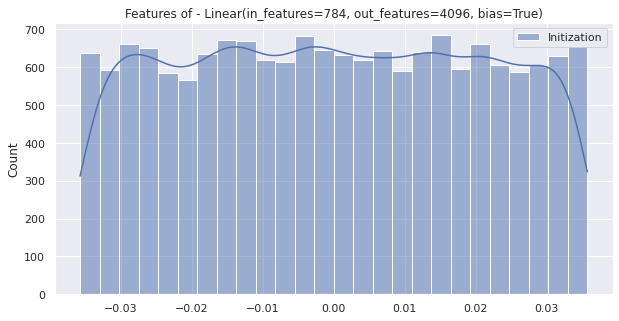

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: /home/betairya/RP_ML/Active-learning-features/lightning_logs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 3.2 M 
1 | decoder    | Sequential | 3.2 M 
2 | classifier | Linear     | 41.0 K
------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
12.937    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-04-15 21:09:22.267482: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
# data
dataset = MNIST('data/', train = True, download = True,
                 transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
               )

mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=512, num_workers = 16)
val_loader = DataLoader(mnist_val, batch_size=512, num_workers = 16)

# model
model = LitAutoEncoder(28 * 28, 10, 4096, noiseAmount = 0.3)
# model = LitClassifier(28 * 28, 10, 4096)

# training
trainer = pl.Trainer(
    gpus=1,
    num_nodes=1,
    enable_progress_bar=True,
    precision=16,
    
    limit_train_batches=1.0,
    limit_val_batches = 0.0,
    
    max_epochs=200
)

# vis = VisualizeFeatures(model.net[0], "Initization")
vis = VisualizeFeatures(model.encoder[0], "Initization")

trainer.fit(model, train_loader, val_loader)

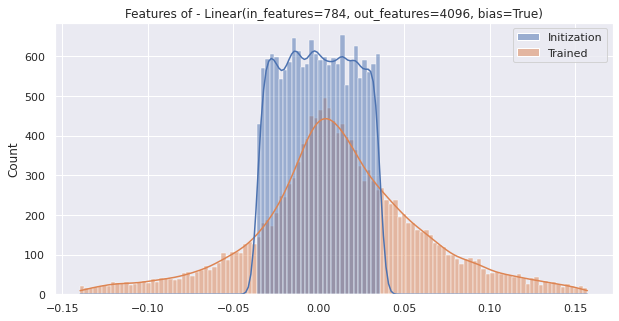

,Initization,Trained
0,-0.023275,0.015163
1,0.018721,0.010256
2,0.016400,0.093570
3,0.031773,-0.067783
4,0.028628,0.031585
...,...,...
16379,-0.024735,NaN
16380,-0.002118,NaN
16381,-0.009519,NaN
16382,-0.031375,NaN


In [6]:
VisualizeFeatures(model.encoder[0], "Trained", df = vis)